In [1]:
import os, sys, copy, time, math, random, numbers, itertools, tqdm, importlib, re
import numpy as np
import numpy.ma as ma
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import rasterio
import torch

from sklearn import metrics
from skimage import transform as trans
from pathlib import Path
from collections.abc import Sequence
from datetime import datetime, timedelta
from scipy.ndimage import rotate
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
from torch import optim
from torch.optim.lr_scheduler import _LRScheduler
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter

from IPython.core.debugger import set_trace

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
module_path = os.path.abspath(os.path.join('../src'))
sys.path.insert(0, module_path)

In [3]:
from custom_dataset import *
from utils import *
from models.unet import *
from model_compiler import *
from accuracy_metric2 import *

In [4]:
# chips_multi_filtered
# ["v_flip", "h_flip", "d_flip", "rotate", "resize", "shift_brightness"]

config = {
    
    # Custom dataset params
    "src_dir": "/home/data",
    "train_dataset_name": "chips_multi_filtered",
    "split_ratio": 0.8,
    "apply_normalization": True,
    "transformations": None,
    "aug_params": {
        "scale_factor": (0.75, 1.3), 
        "rotation_degree": (-180, -90, 90, 180), 
        "bshift_gamma_range": (0.2, 2), 
        "bshift_subs": (4, 4, 4), 
        "patch_shift": True
    },

    # DataLoader
    "train_BatchSize": 10,
    "val_test_BatchSize": 1,

    # model initialization params
    "n_classes": 14,
    "input_channels": 12,
    "filter_config": (64, 128, 256, 512, 1024, 1024),
    "use_skipAtt": False,
    "train_dropout_rate": 0.15,

    # Model compiler params
    "working_dir": "/home/workdir",
    "out_dir": "output2",
    "gpuDevices": [0],
    "init_type": "kaiming",
    "params_init": "/home/data/chkpt/Unet_final_state.pth",
    "freeze_params": None,
    
    # Model fitting
    "epochs": 50,
    "optimizer": "sam",
    "LR": 0.01,
    "LR_policy": "PolynomialLR",
    "criterion": "TverskyFocalCELoss(ignore_index=0)",
    "momentum": 0.95,
    "resume": False,
    "resume_epoch": None,
    "lr_prams": {
        # StepLR & MultiStepLR
        "step_size" : 3,
        "milestones": [5, 10, 20, 35, 50, 70, 90], 
        "gamma": 0.98, 
        # ReduceLROnPlateau
        "mode": "min", 
        "factor": 0.8, 
        "patience": 3, 
        "threshold": 0.0001,
        "threshold_mode": "rel",
        "min_lr": 3e-6,
        # PolynomialLR
        "max_decay_steps": 50,
        "min_learning_rate": 1e-5,
        "power": 0.85,
        # CyclicLR
        "base_lr": 3e-5,
        "max_lr": 0.01,
        "step_size_up": 1100,
        "mode": "triangular"
    },
    
    # Model accuracy evaluation
    "val_metric_fname" : "validate_metricsV2_4.csv"   
}

In [5]:
# Read the input dataset for training, pre-process it, and generate a 'torch.utils.Dataset' object 
# that can be accepted to get loaded into the model.
train_dataset = CropData(src_dir=config["src_dir"],
                         usage="train",
                         dataset_name=config["train_dataset_name"],
                         split_ratio=config["split_ratio"],
                         apply_normalization=config["apply_normalization"],
                         trans=config["transformations"], 
                         **config["aug_params"])

100%|███████████████████████████████████████████████████████████████████████████████| 3390/3390 [08:10<00:00,  6.91it/s]

------ train dataset with 3390 patches created ------


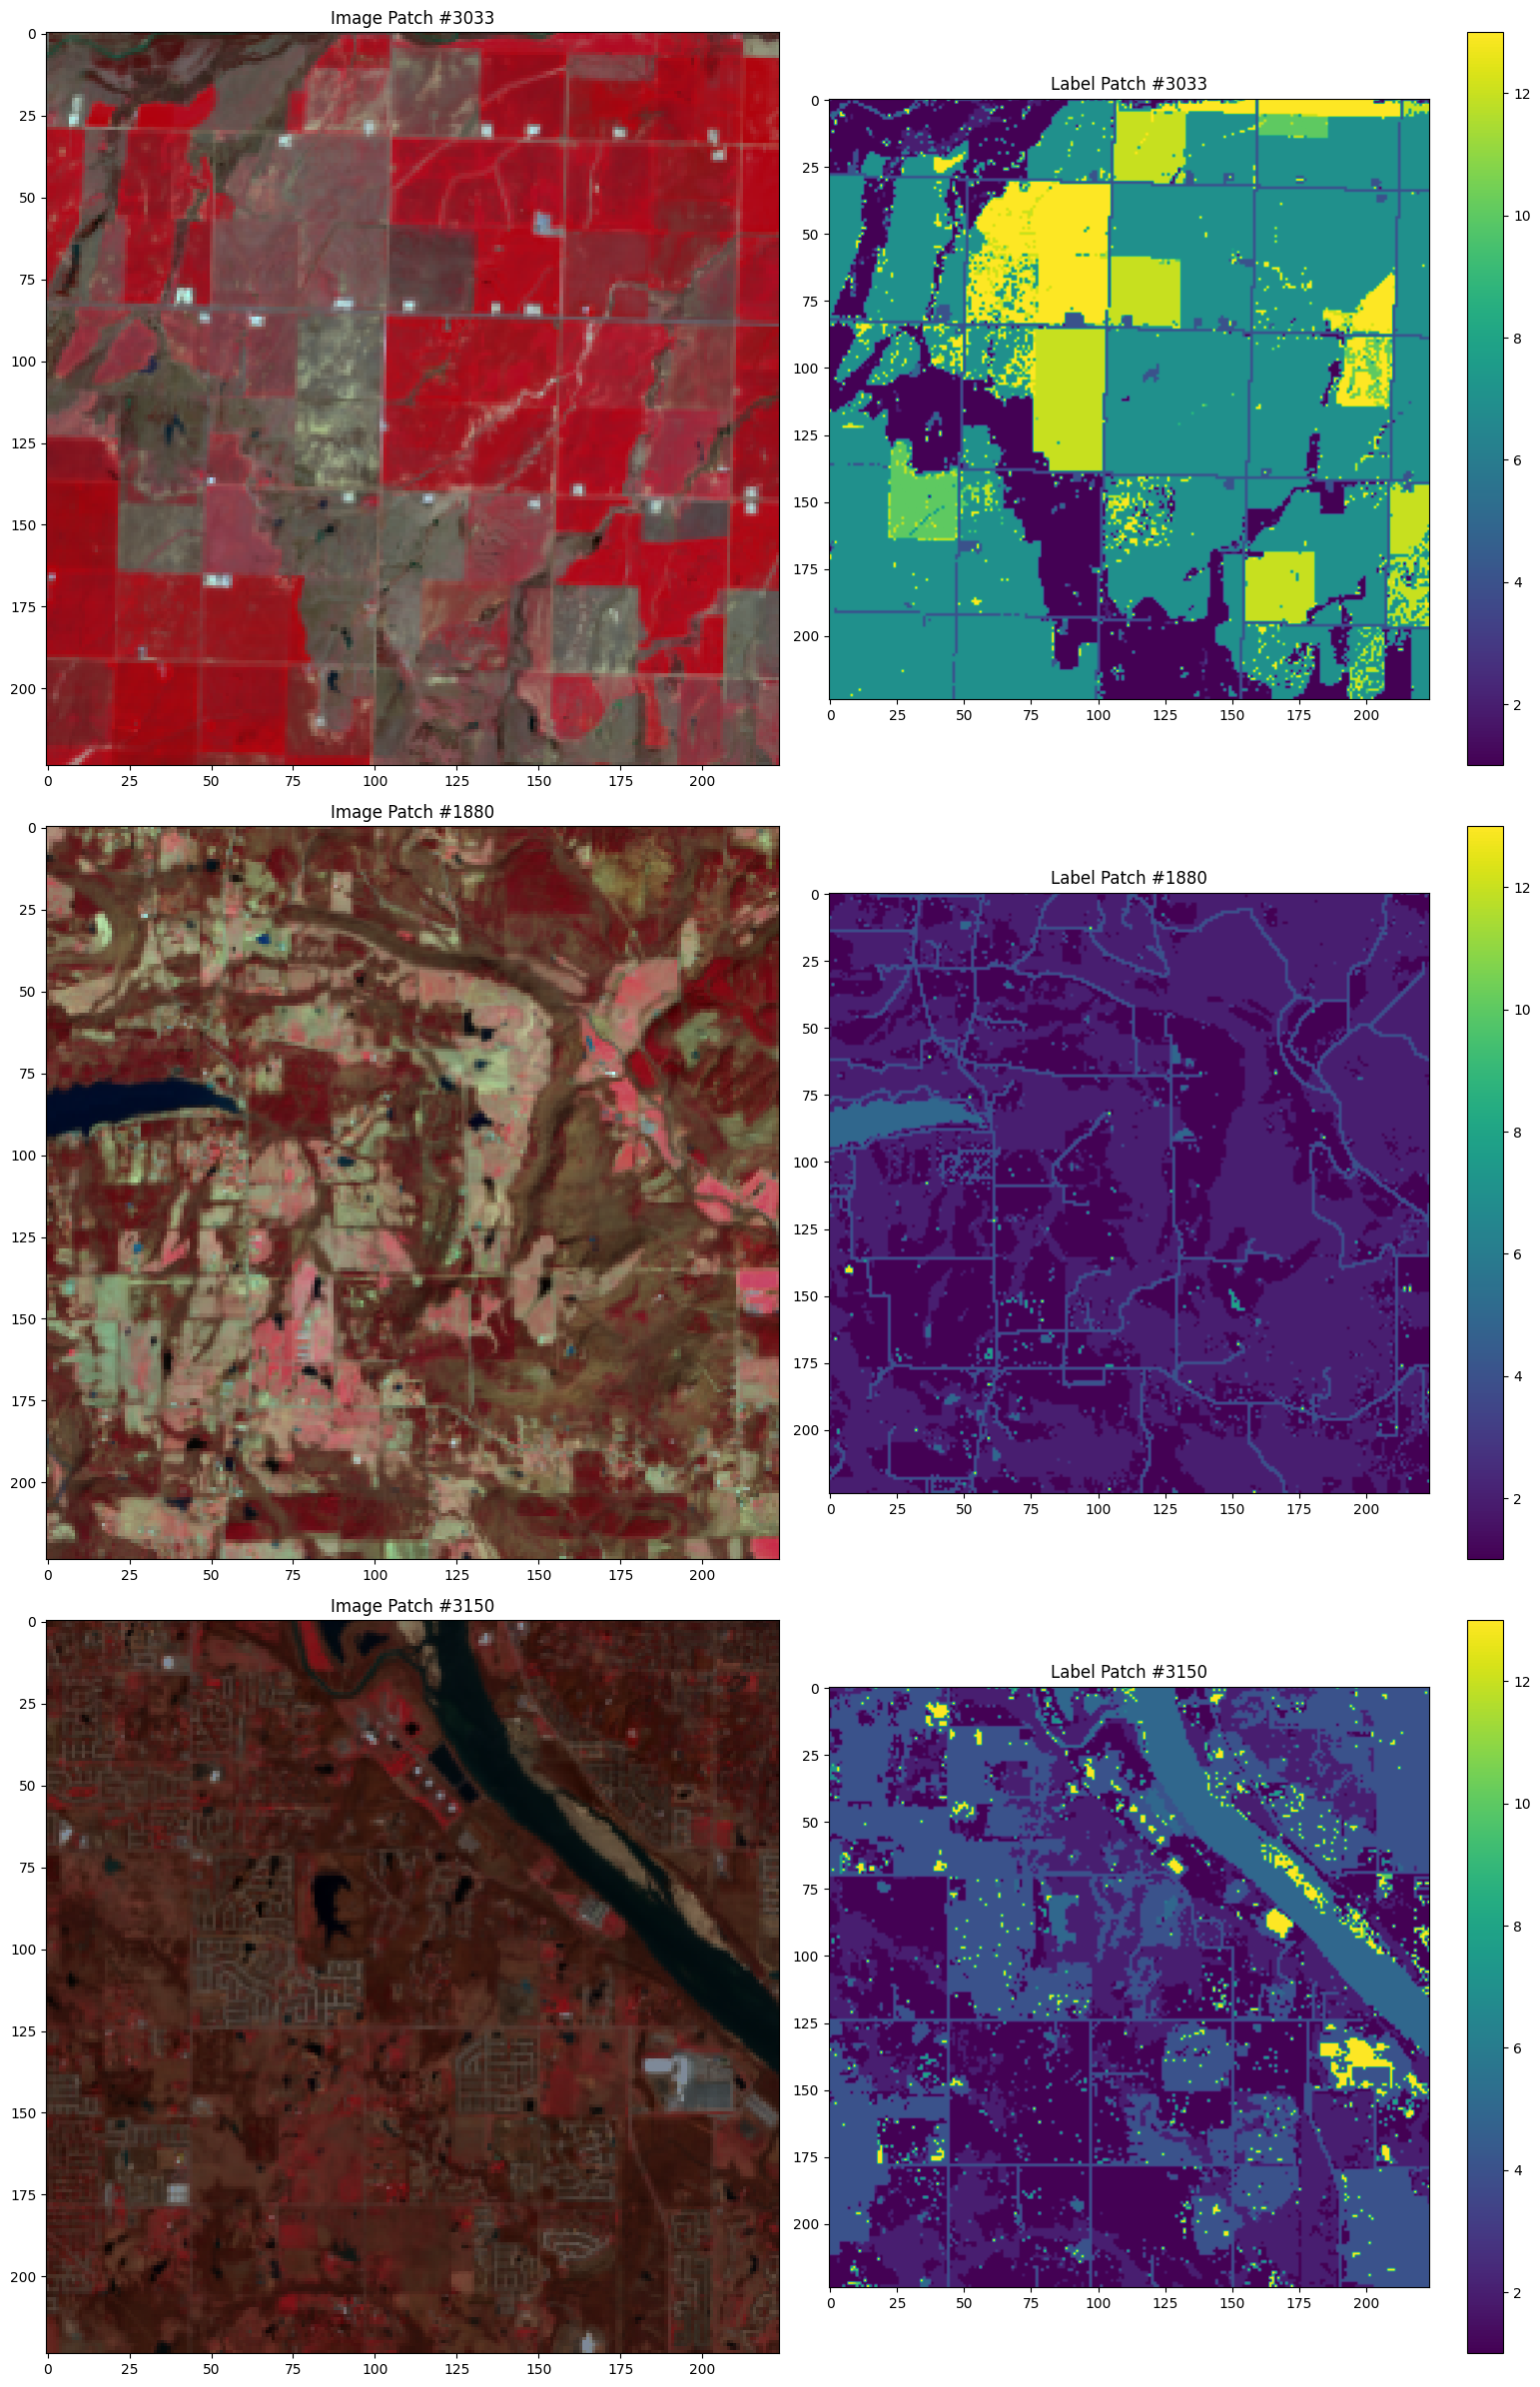

In [6]:
show_random_patches(train_dataset, sample_num=3, rgb_bands=(3, 2, 1))

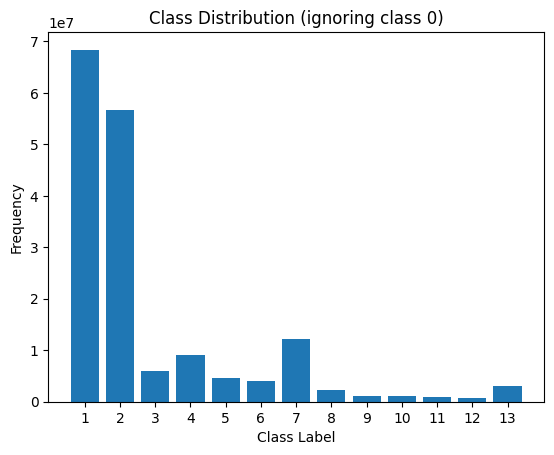

In [7]:
# Check the distribution of categories in a dataset
labels_count = get_labels_distribution(train_dataset)
plot_labels_distribution(labels_count)

In [ ]:
# Batchify the training dataset and put it on the defined 'Device'.
train_loader = DataLoader(train_dataset,
                          batch_size=config["train_BatchSize"], 
                          shuffle=True)

In [8]:
# Read the input dataset for validation, pre-process it and generate a 'torch.utils.Dataset' object 
# that can be accepted to get loaded into the model.
val_dataset = CropData(src_dir=config["src_dir"],
                       usage="validation",
                       dataset_name=config["train_dataset_name"],
                       split_ratio=config["split_ratio"],
                       apply_normalization=config["apply_normalization"])

100%|█████████████████████████████████████████████████████████████████████████████████| 848/848 [02:22<00:00,  5.93it/s]

------ validation dataset with 848 patches created ------


In [ ]:
# Making a subset of the evaluation dataset for the purpose of debugging the code. Not part of the required steps in the pipeline.

from torch.utils.data import Subset

subset_indices = torch.arange(0, 26)
sample_val = Subset(val_dataset, subset_indices)

val_loader = DataLoader(sample_val, 
                        batch_size=config["val_test_BatchSize"], 
                        shuffle=False)

In [ ]:
# Check the distribution of categories in a dataset
labels_count = get_labels_distribution(val_dataset)
plot_labels_distribution(labels_count)

In [9]:
# Batchify the validation dataset and put it on the defined 'Device'.
val_loader = DataLoader(val_dataset, 
                        batch_size=config["val_test_BatchSize"], 
                        shuffle=False)

In [10]:
# Initialize the model
model = Unet(n_classes=config["n_classes"], 
             in_channels=config["input_channels"], 
             use_skipAtt=config["use_skipAtt"],
             filter_config=config["filter_config"],
             dropout_rate=config["train_dropout_rate"])

In [11]:
# Compile the model as vanilla or pre-trained object with 'fit', 'save', 'accuracy_evaluation'
# and 'inference' methods. It also has checkpointing and resume capabilities and generates 
# tensorboard reports and graphs.
compiled_model = ModelCompiler(model,
                               working_dir=config["working_dir"],
                               out_dir=config["out_dir"],
                               num_classes=config["n_classes"],
                               inch=config["input_channels"],
                               gpu_devices=config["gpuDevices"],
                               model_init_type=config["init_type"], 
                               params_init=config["params_init"],
                               freeze_params=config["freeze_params"])

----------GPU available----------
total number of trainable parameters: 103.4M
---------- Pre-trained model compiled successfully ----------


In [ ]:
# train and validate the model for the defined number of epochs
compiled_model.fit(train_loader,
                   val_loader, 
                   epochs=config["epochs"], 
                   optimizer_name=config["optimizer"], 
                   lr_init=config["LR"],
                   lr_policy=config["LR_policy"], 
                   criterion=config["criterion"], 
                   momentum=config["momentum"],
                   resume=config["resume"],
                   resume_epoch=config["resume_epoch"],
                   **config["lr_prams"])

In [ ]:
# Same model parameters
compiled_model.save(save_object="params")

In [ ]:
# First procedure to generate the accuracy metrics
compiled_model.accuracy_evaluation(val_loader, filename=config["val_metric_fname"])

---------------- Start evaluation ----------------


/home/workdir/src/accuracy_metric2.py:22: RuntimeWarning: invalid value encountered in true_divide
  acc = np.diag(self.confusion_matrix) / self.confusion_matrix.sum(axis=1)
/home/workdir/src/accuracy_metric2.py:47: RuntimeWarning: invalid value encountered in true_divide
  iou = (2 * np.diag(self.confusion_matrix)) / (
/home/workdir/src/accuracy_metric2.py:32: RuntimeWarning: invalid value encountered in true_divide
  precision = tp / (tp + fp)
/home/workdir/src/accuracy_metric2.py:42: RuntimeWarning: invalid value encountered in true_divide
  recall = tp / (tp + fn)


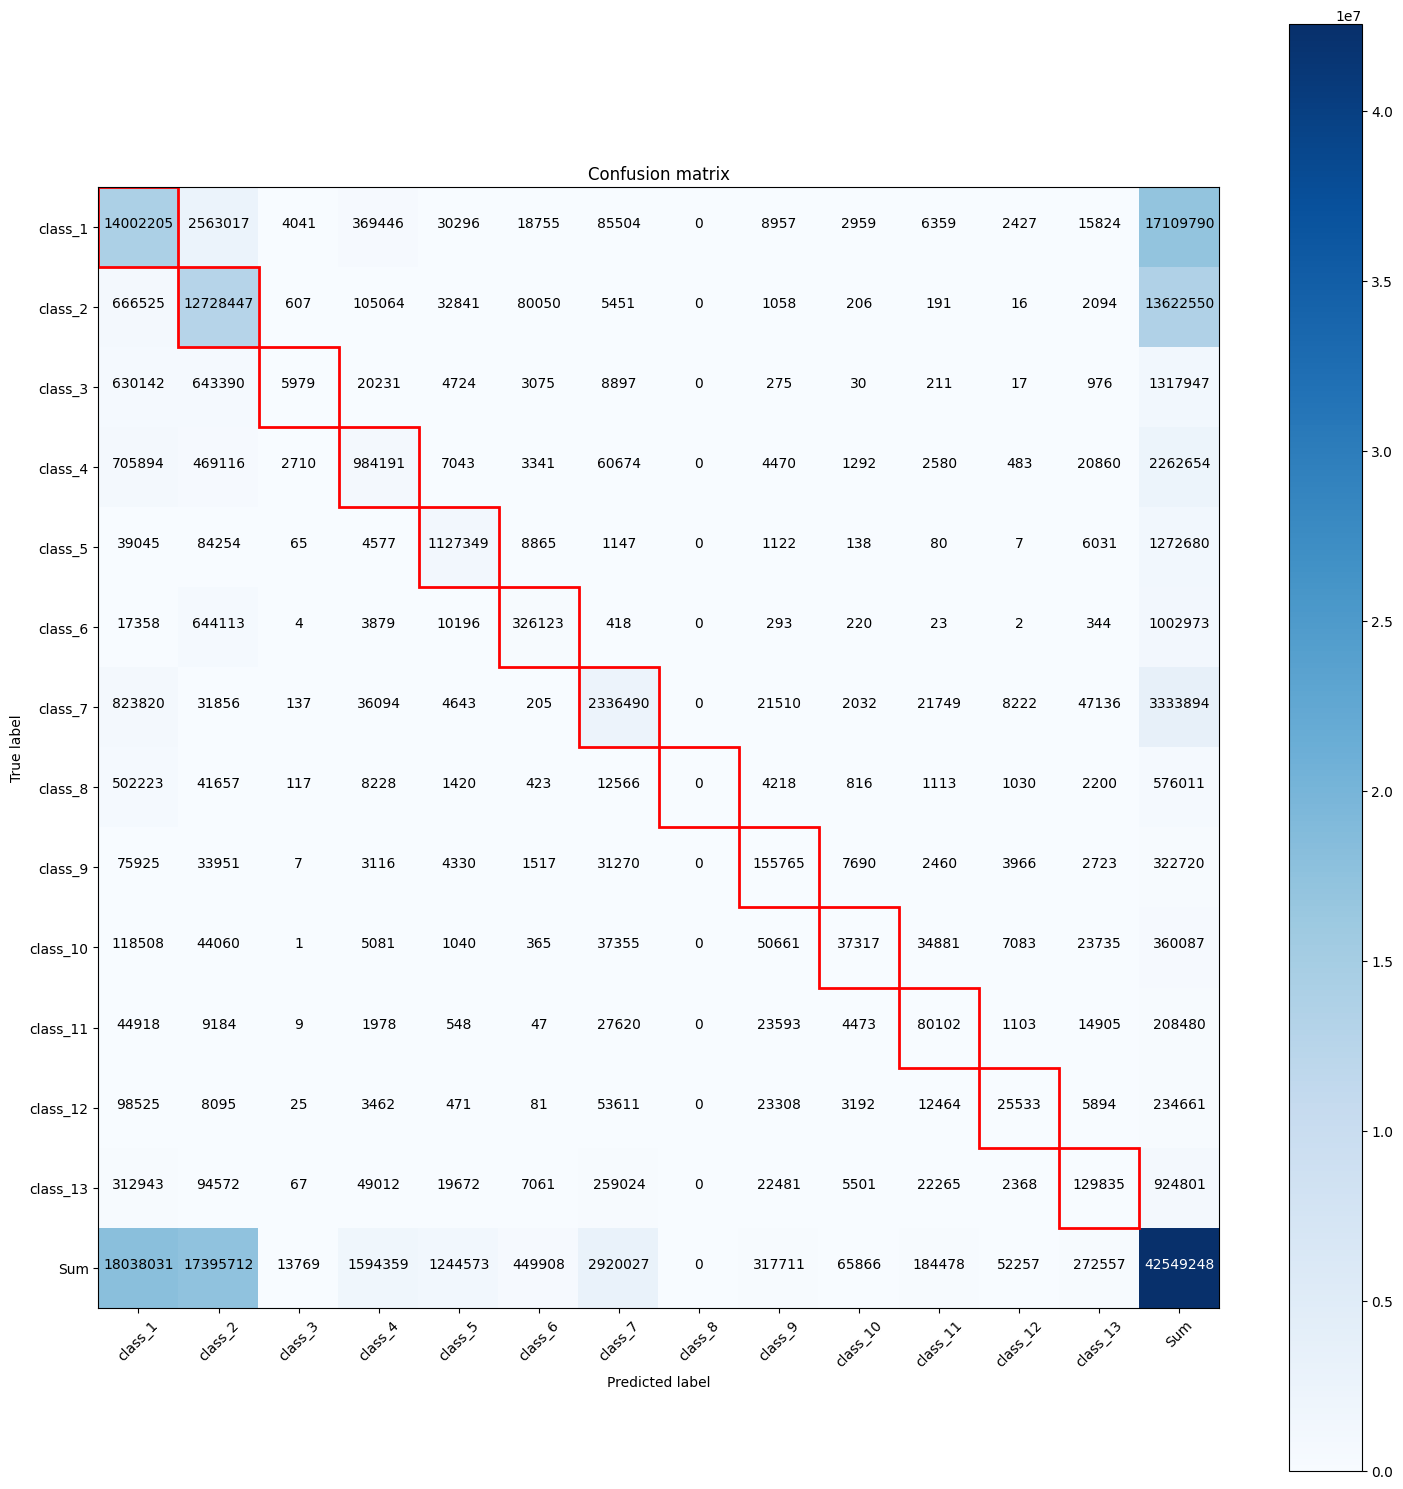

---------------- Evaluation finished in 26s ----------------


In [12]:
# Second procedure to generate the accuracy metrics
compiled_model.accuracy_evaluation(val_loader, filename=config["val_metric_fname"])